refer to https://blog.csdn.net/weixin_45745242/article/details/119830886

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import aesara.tensor as at
import seaborn as sns
from sklearn import mixture
import dill, aesara
import time
from scipy.stats import multivariate_normal as mvn

In [25]:
x,y = np.mgrid[-3:9:0.1, -3:9:0.1]
pos = np.dstack((x, y))

In [27]:
k = 3
means = np.array([1,1,3,3,5,5]).reshape((3,2))
cov = np.array([1,-0.8,-0.8,1,1,0.8,0.8,1,1,-0.8,-0.8,1]).reshape((3,2,2))
alpha = np.array([8,4,8])
w = np.random.dirichlet(alpha)

In [29]:
com1 = mvn(mean=means[0], cov=cov[0]).pdf(pos)
com2 = mvn(mean=means[1], cov=cov[1]).pdf(pos)
com3 = mvn(mean=means[2], cov=cov[2]).pdf(pos)
likelihood = w[0]*com1 + w[1]*com2 + w[2]*com3

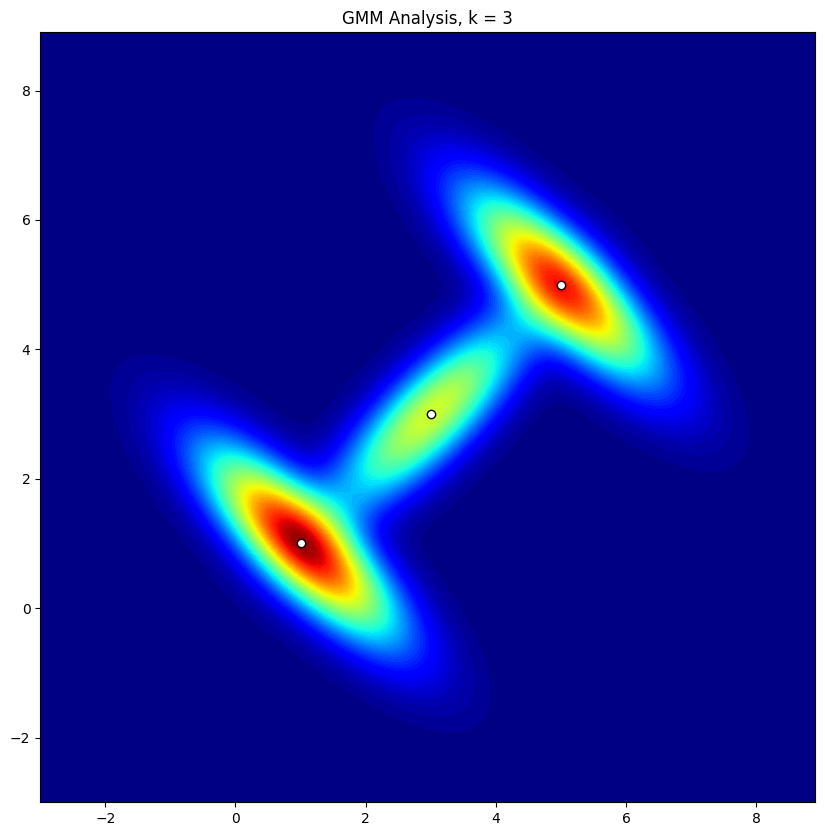

In [40]:
flg = plt.figure(figsize=(10,10))
ax = flg.add_subplot(111)
ax.contourf(x, y, likelihood,levels=100,cmap='jet')
ax.scatter(means[:,0],means[:,1],color='white',edgecolors='black')
plt.title('GMM Analysis, k = 3')
plt.show()

In [127]:
%%time
with pm.Model() as model:
    comp1 = pm.MvNormal.dist(mu=means[0], cov=cov[0], shape=2)
    comp2 = pm.MvNormal.dist(mu=means[1], cov=cov[1], shape=2)
    comp3 = pm.MvNormal.dist(mu=means[2], cov=cov[2], shape=2)
    likelihood = pm.Mixture('likelihood', w=w, comp_dists=[comp1, comp2, comp3], shape=2)
    trace = pm.sample(2000, 
                      step=pm.Slice(), 
                      tune=2000)
    

Multiprocess sampling (4 chains in 4 jobs)
Slice: [likelihood]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


CPU times: user 1.84 s, sys: 174 ms, total: 2.01 s
Wall time: 2.94 s


array([[<Axes: title={'center': 'likelihood'}>,
        <Axes: title={'center': 'likelihood'}>]], dtype=object)

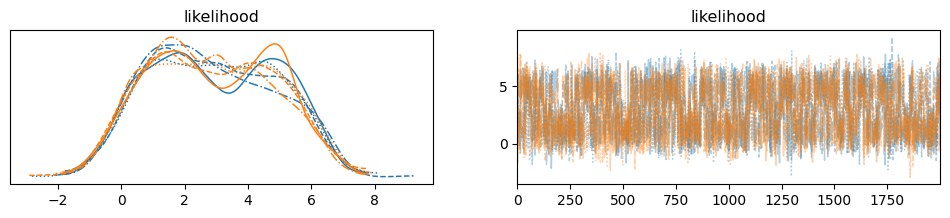

In [71]:
az.plot_trace(trace)


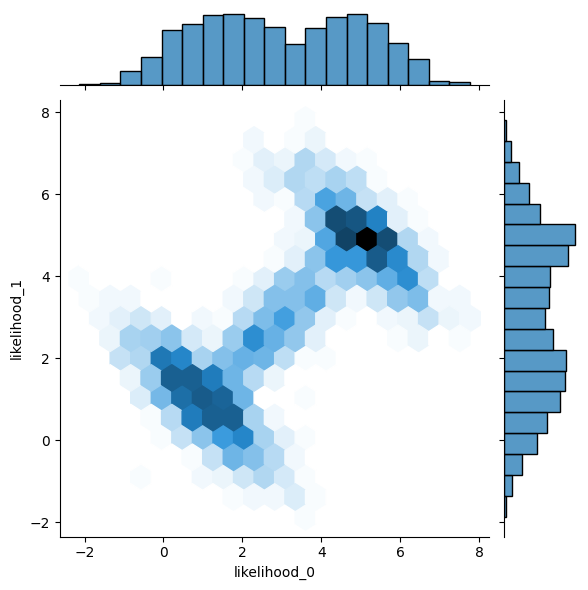

In [76]:
dftrace = trace.posterior.likelihood.values[0] # select the first chain
dftrace = pd.DataFrame(dftrace, columns=['likelihood_0','likelihood_1']) # convert to DataFrame
sns.jointplot(data = dftrace, x = 'likelihood_0', y = 'likelihood_1', kind='hex')


$$ f(z) = \frac{1}{\sqrt{2\pi \cdot |\Sigma|}} \exp\left(-\frac{1}{2}(z - \mu)^T \Sigma^{-1} (z - \mu)\right) $$


In [89]:
cov_inverse = np.linalg.inv(cov) # inverse of covariance matrix
z = at.matrix('z') # define a symbolic variable
z.tag.test_value=pm.floatX([[0,0]])
def gmm2dliklihood(z):
    z = z.T
    comp1 = 1/np.sqrt(2*np.pi*np.linalg.det(cov)[0])*np.exp(-1/2*(
        (z[0]-means[0,0])**2*cov_inverse[0,0,0]
        +(z[0]-means[0,0])*(z[1]-means[0,1])*cov_inverse[0,0,1]
        +(z[1]-means[0,1])*(z[0]-means[0,0])*cov_inverse[0,1,0]
        +(z[1]-means[0,1])**2*cov_inverse[0,1,1]))
    comp2 = 1/np.sqrt(2*np.pi*np.linalg.det(cov)[1])*np.exp(-1/2*(
         (z[0]-means[1,0])**2*cov_inverse[1,0,0]
        +(z[0]-means[1,0])*(z[1]-means[1,1])*cov_inverse[1,0,1]
        +(z[1]-means[1,1])*(z[0]-means[1,0])*cov_inverse[1,1,0]
        +(z[1]-means[1,1])**2*cov_inverse[1,1,1]))
    comp3 = 1/np.sqrt(2*np.pi*np.linalg.det(cov)[2])*np.exp(-1/2*(
         (z[0]-means[2,0])**2*cov_inverse[2,0,0]
        +(z[0]-means[2,0])*(z[1]-means[2,1])*cov_inverse[2,0,1]
        +(z[1]-means[2,1])*(z[0]-means[2,0])*cov_inverse[2,1,0]
        +(z[1]-means[2,1])**2*cov_inverse[2,1,1]))
    return w[0]*comp1 + w[1]*comp2 + w[2]*comp3


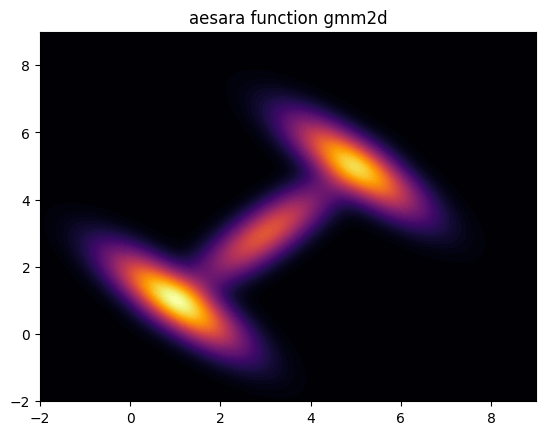

In [106]:
gmm2dliklihood_plot = aesara.function([z],gmm2dliklihood(z))
grid = pm.floatX(np.mgrid[ -2:9:1000j, -2:9:1000j])
grid2d = grid.reshape(2, -1).T
pdf = gmm2dliklihood_plot(grid2d)
plt.contourf(grid[0], grid[1], pdf.reshape(1000, 1000), cmap='inferno',levels=80)
plt.title('aesara function gmm2d')
plt.show()


Multiprocess sampling (4 chains in 4 jobs)
Slice: [gmm2dlike]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


CPU times: user 1.28 s, sys: 207 ms, total: 1.48 s
Wall time: 1.56 s


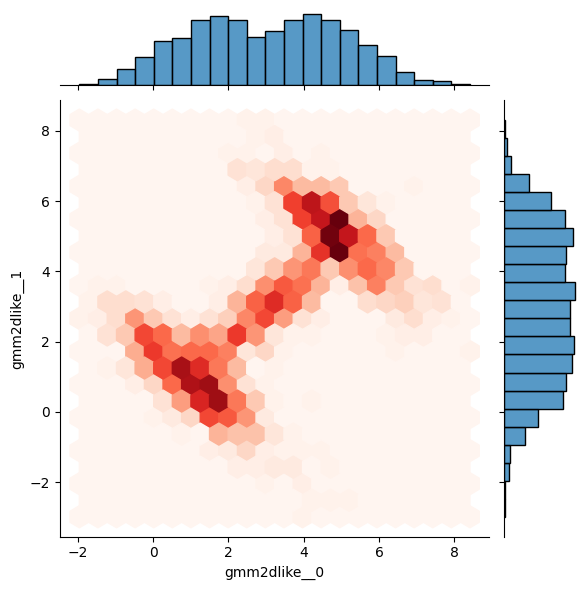

In [125]:
%%time
def gmmlogp(z):
    return np.log(gmm2dliklihood(z))
with pm.Model() as model:
    gmm2dlike = pm.DensityDist("gmm2dlike", logp=gmmlogp, shape=(2,))
    trace = pm.sample(2000, step=pm.Slice(), tune=2000)
dftrace = trace.posterior.gmm2dlike.values[0] # select the first chain
dftrace = pd.DataFrame(dftrace, columns=['gmm2dlike__0','gmm2dlike__1']) # convert to DataFrame
sns.jointplot(data=dftrace, x='gmm2dlike__0', y='gmm2dlike__1', kind='hex', cmap='Reds')


CPU times: user 807 ms, sys: 196 ms, total: 1 s
Wall time: 140 ms


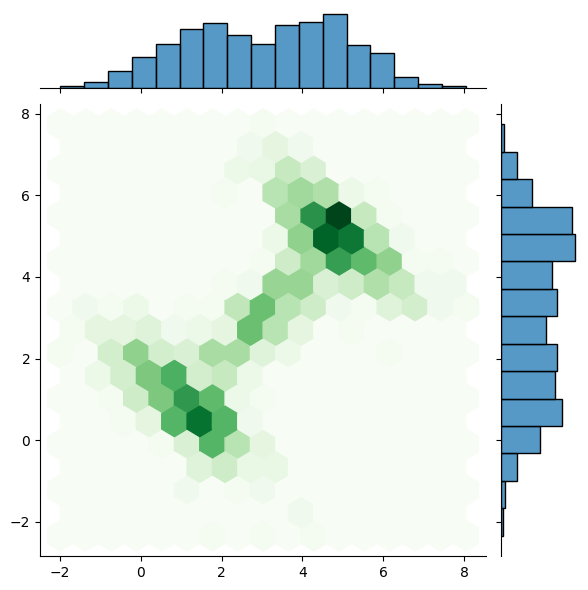

In [126]:
%%time
# Using sklearn to sample
skgmm = mixture.GaussianMixture(n_components=k
                                , covariance_type='full'
                                , weights_init=w
                                ,means_init=means
                               )
skgmm.fit(trace.posterior.gmm2dlike.values[0])
sksamples, index = skgmm.sample(1000)
sns.jointplot(x=sksamples[:,0], y=sksamples[:,1], kind='hex', cmap='Greens')
